<img src="img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Módulo 7</font></h2>



<h1><font color="#00586D" size=5>Creación de modelos de pronóstico clásicos</font></h1>

<br><br><br>
<div style="text-align: right">
<font color="#00586D" size=3>Enrique González</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube III </font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. ARIMA mediante Box-Jenkins](#section2)
* [3. ARIMA mediante búsqueda](#section3)



In [1]:
import matplotlib.pyplot as plt

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
# Por defecto usamos el backend inline
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

# La libreta ocupa así el 95% de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

---

<a id="section1"></a>
## <font color="#00586D"> 1. Introducción</font>
<br>

En esta práctica introducimos como útilizar un modelo clásico para el pronóstico de series temporales, ARIMA, en `python`, usando para ello dos métodos de entrenamiento, un más clásico, usando el método de Box-Jenkins y otro usando directamente Grid-Search.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Recordad__: Cread un `virtualenv` e instalad las librerias del `requirement.txt`para poder continuar con la práctica.  
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

En esta práctica continuaremos con los conjuntos de datos de las prácticas anteriores. Para facilitar el acceso a la descripción de estos datos, os la incluyo a continuación. 

Son datos meteorológicos de dos estaciones meteorológicas españolas, la estación meteorológica del Retiro en Madrid y la estación meteorológica de La Coruña. Estos datos los podéis encontrar en `datos/meteo_retiro.csv`, con datos meteorológicos diarios desde el 1 de Enero de 1920 y `datos/meteo_coruña.csv`, con datos meteorológicos desde el 1 de Octubre de 1930.  

modeloA continuación os indicamos la descripción de cada una de las columnas presentes en estas tablas:

- `FECHA`: Fecha en formato (aaaa-mm-dd) . Si lo abre con una hoja de cálculo, es posible que interprete el campo como fecha y lo vea en el formato habitual dd/mm/aaaa
- `INDICATIVO`: Identificador de Estación Meteorológica (Valor de 4 ó 5 caracteres)
- `NOMBRE`: Nombre de la Estación
- `PROVINCIA`: Provincia en la que se encuentra
- `ALTITUD`: Altitud (metros)
- `TMEDIA`: Temperatura media (ºC)
- `PRECIPITACION`: Precipitación (mm = l/m2)
- `TMIN`: Temperatura minima (ºC)
- `HORATMIN`: Hora de Temperatura mínima (hh:mm)
- `TMAX`: Temperatura Máxima (ºC)
- `HORATMAX`: Hora de Temperatura máxima (hh:mm)
- `DIR`: Dirección del viento (decenas de grado)
- `VELMEDIA`: Velocidad media (m/s)
- `RACHA`: Racha (m/s)
- `HORARACHA`: Hora Racha (hh:mm)
- `SOL`: Horas de Sol (horas)
- `PRESMAX`: Presión máxima (hPa)
- `HORAPRESMAX`: Hora de Presión Máxima (hh:mm)
- `PRESMIN`: Presión Mínima (hPa)
- `HORAPRESMIN`: Hora de Presión Mínima (hh:mm)


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section2"></a>
## <font color="#00586D"> 2. ARIMA mediante Box-Jenkins</font>
<br>

Como sabéis, ARIMA es un acrónimo de `AutoRegressive Integrated Moving Average`. Es una generalización de los modelos ARMA que añade la noción de integración. Este acrónimo además captura los principales aspectos del modelo en si mismo:
- AR (`Autoregression`). Un modelo que usa la relación de depencia entre la observación y un cierto número de observaciones anteriores. 
- I (`Integrated`). El uso de diferencias (ver práctica anterior) para hacer que la serie sea estacionaria. 
- MA (`Moving Average`): un modelo que usa la dependencia de una observación con los errores residuales de una media móvil en las observaciones anteriores. 

Cada uno de estos componentes se específican, en el modelo general de ARIMA, con un parámetro de tipo entero. La notación estándar usada para denotar este tipo de modelos es `ARIMA(p,d,q)`, en la que cada uno de los parámetros significa:
- `p`: El número de observaciones de momentos anteriores incluídas en el modelo. 
- `d`: El número de diferencias que se debe utilizar. 
- `q`: El tamaño de la ventana de media móvil. 

A parte del método ARIMA clásico, también podemos encontrar el método ARIMA estacional (SARIMA) que tiene 4 parámetros más: tres parámetros con significado similar a los de ARIMA y el tamaño de la estaación. Nos referiremos a él como `SARIMA(p,d,q,P,D,Q,S)`, que vienen a significar lo mismo pero en el que los retardos se toman de manera estacional. 

El método de Box-Jenkins es un método que nos proporciona algunas pautas para elegir estos parámetros:
1. Comprobar si la serie es estacionaria. Si es estacionaria, no es necesario utilizar diferencias (`d=0`). En otro caso, aplicar diferencias hasta que la serie sea estacionaria (podéis seguir el procedimiento de la práctica anterior). El número de diferencias aplicadas será el valor de `d`. 
2. Para elegir los parámetros `p` y `q` del modelo ARMA nos ayudaremos de dos gráficos de diagnóstico:
    - Gráfico de autocorrelación (ACF). Resume la correlación entre una observación y los valores de los instantes anteriores (retardos). El eje x muestra el retardo y el eje y muestra la correlación (entre -1 y 1). 
    - Gráfico de autocorrelación parcial (PACF). El gráfico resume las correlaciones para una observación y un solo instante anterior obviando las que se deben a retardos anteriores al que se está considerando.  


En estas gráficas podemos observar:
- Si observamos que el gráfico ACF sufre un corte en un cierto retardo `k`, mientras que el valor del gráfico de autocorrelación parcial decrece gradualmente, estableceríamos como parámetros `q=k` y `p=0`
- Si ocurre al contrario, estableceríamos `p=k` y `q=0`
- Si ambas gráficas decrecen gradualmente, el orden no es obvio, por lo que recurriremos a probar valores y ver el modelo resultante. 

Hay que indicar que este método es una **heurística** y como tal establece una buena práctica para encontrar los valores de este tipo de modelos. Este método supone que los datos cumplen con un modelo ARIMA. En la práctica, es posible que no encontréis de forma tan clara estos parámetros. 


### <font color="#00586D"> 2.1. ARIMA básico</font>

Vamos a ejemplificar este método partiendo de la serie que generamos el a Práctica 3 sin estaciones, para ver como utilizar este método en `python`. 

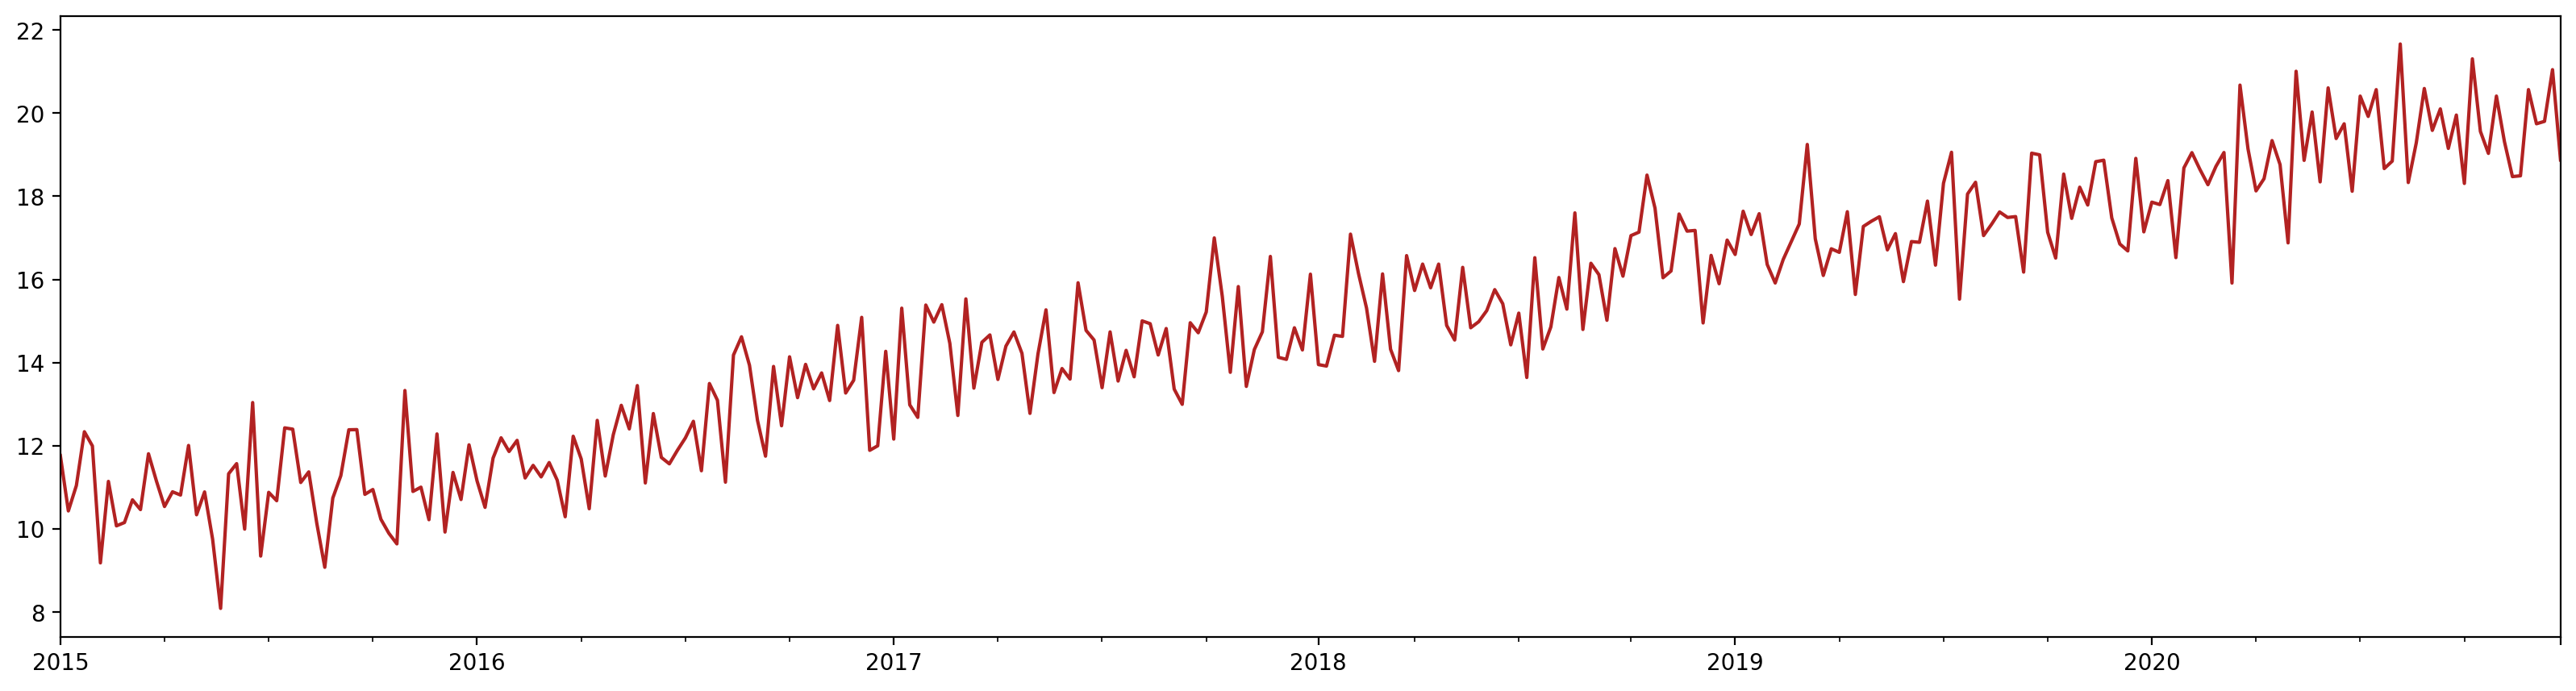

In [3]:
import pandas as pd
import numpy as np
np.random.seed(0)

dates = pd.date_range('2015-01-01', '2020-12-31', freq='W')
size = dates.shape[0]    

level = np.full(size, 10)
noise = np.random.randn(size)
trend = np.linspace(start=0, stop=10, num=size)
noisy_trend_data = level + noise + trend
ts = pd.Series(noisy_trend_data, index=dates)
ts.plot(figsize=(20,5), color='firebrick');

Vamos a dividir el conjunto en entrenamiento y test. 

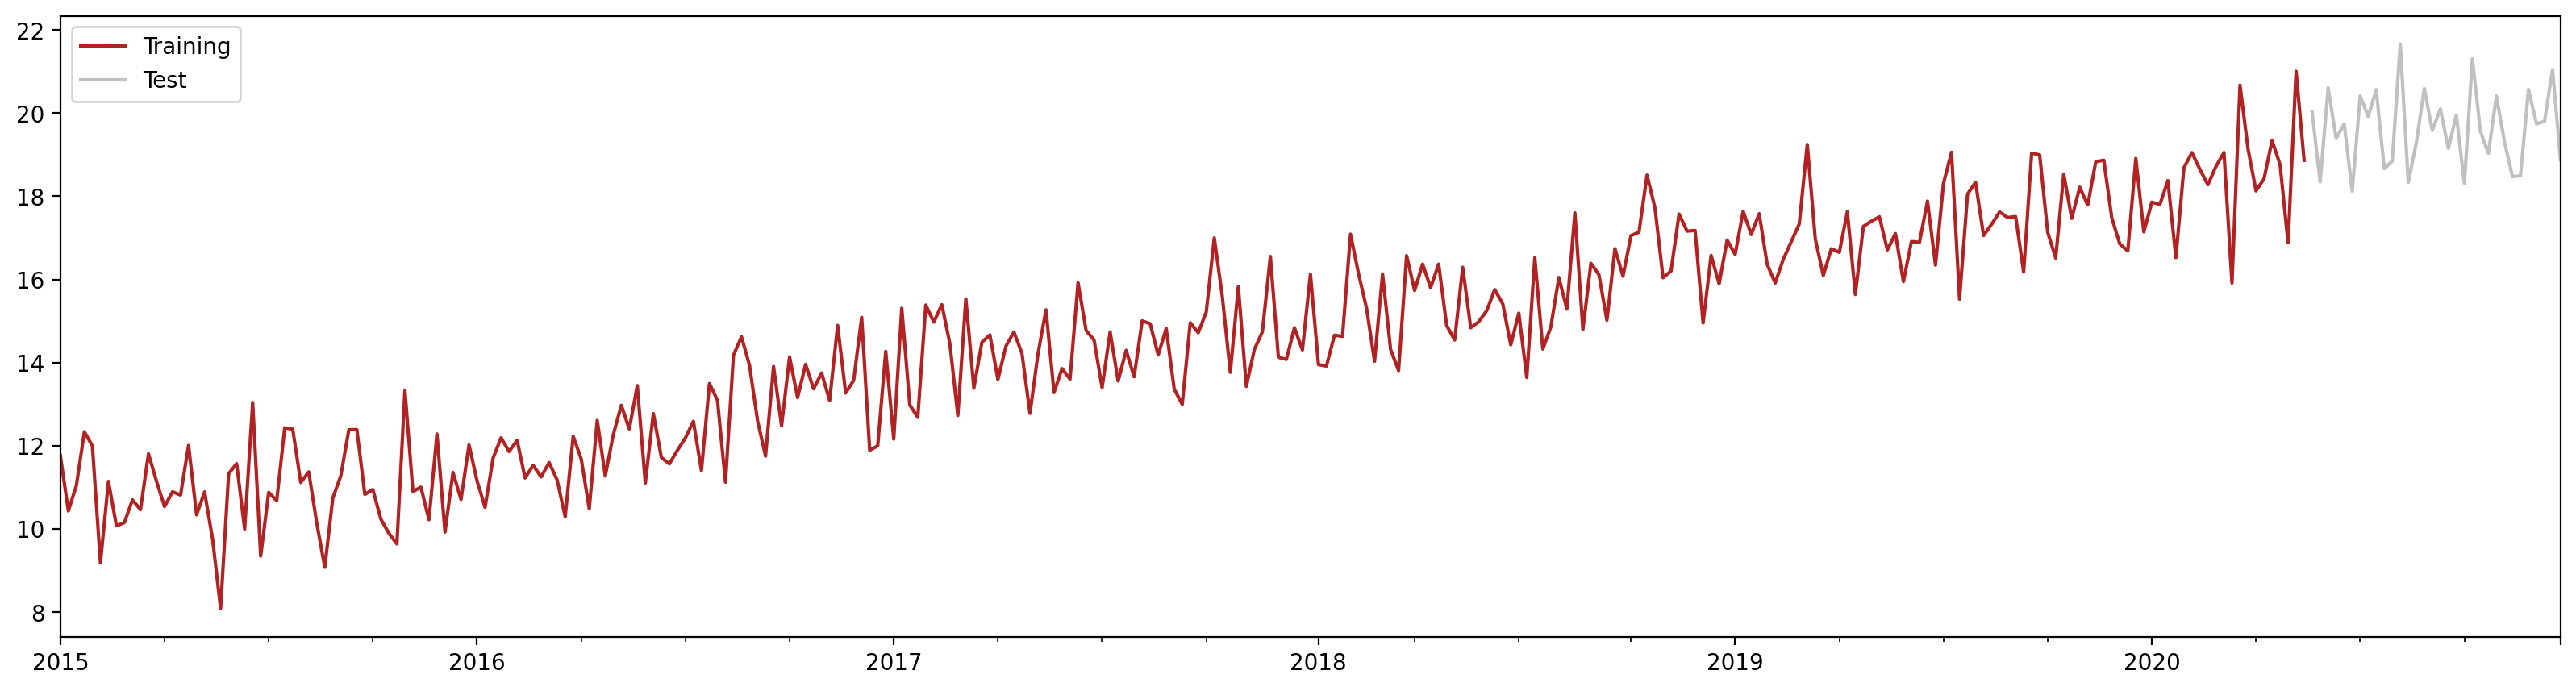

In [4]:
n = len(ts) 
split = 0.1 # % de datos para test
n_training = int((1-split)*n)
training = ts[:n_training]
test = ts[n_training:]

training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
plt.legend(['Training', 'Test'])

La serie no es estacionaria. Veamos si podemos hacerla estacionaria tomando la primera diferencia. 

<AxesSubplot: >

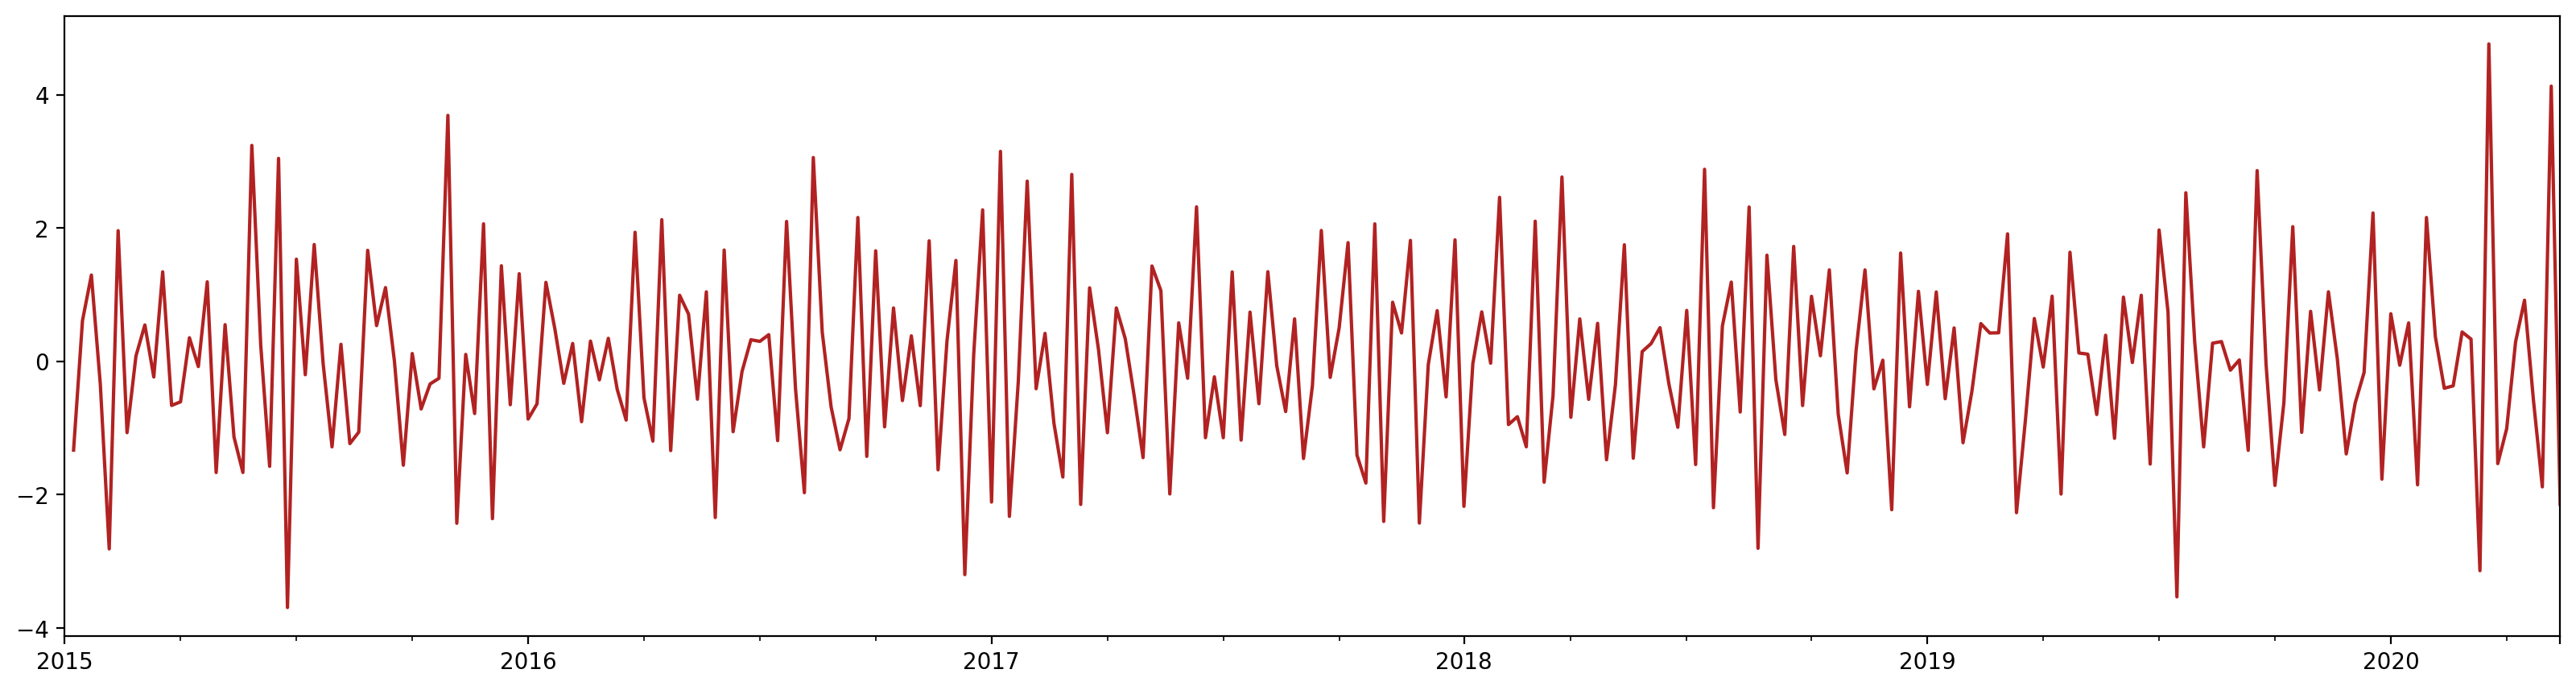

In [5]:
training_1d = (training - training.shift(1))
training_1d.plot(figsize=(20,5), color='firebrick')

Parece estacionaria, aunque usaremos el test de Dickey-Fuller para comprobarlo. 

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(training_1d.fillna(method='bfill'))[1]

2.796602141033874e-12

Siguiendo el método de Box-Jenkins, ya tenemos el parámetro `d=1` ya que solo hemos tenido que aplicar una diferencia. 

Ahora utilicemos las gráficas ACF y PACF. Para ello, podemos usar `statsmodels`.

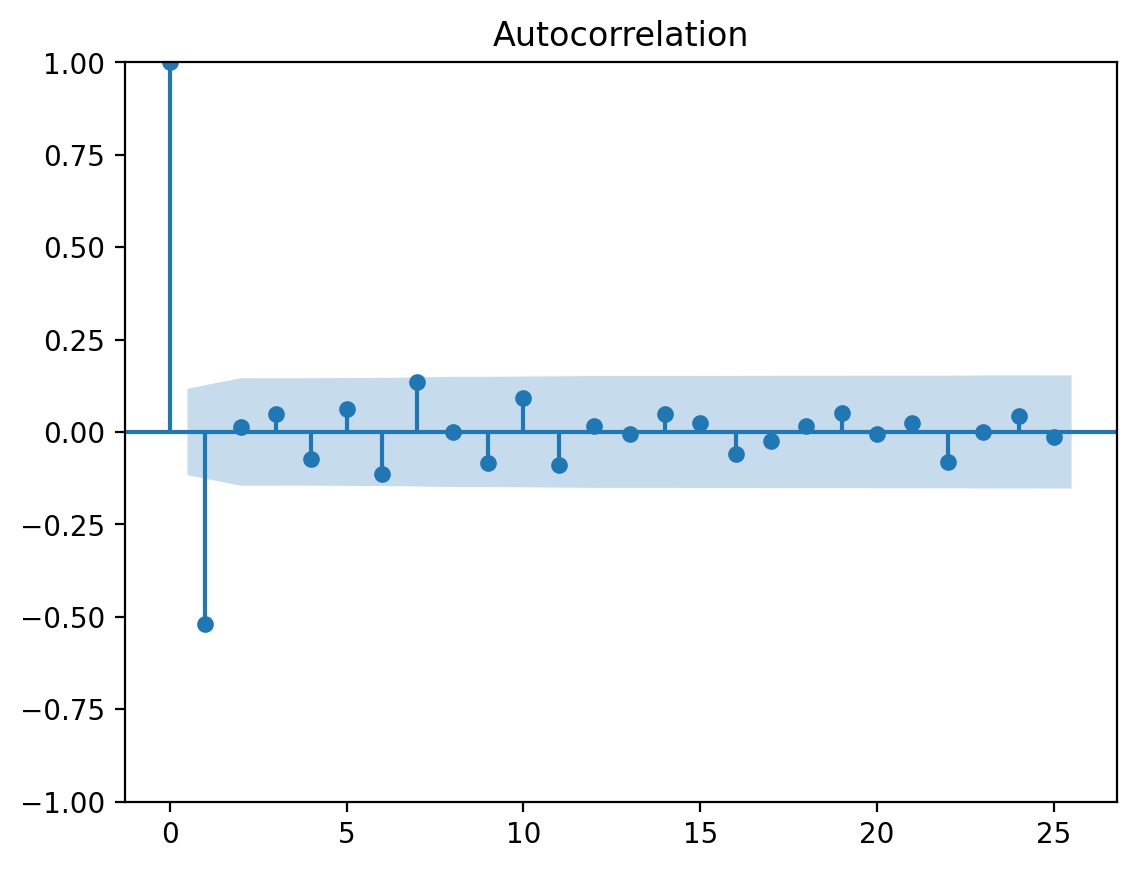

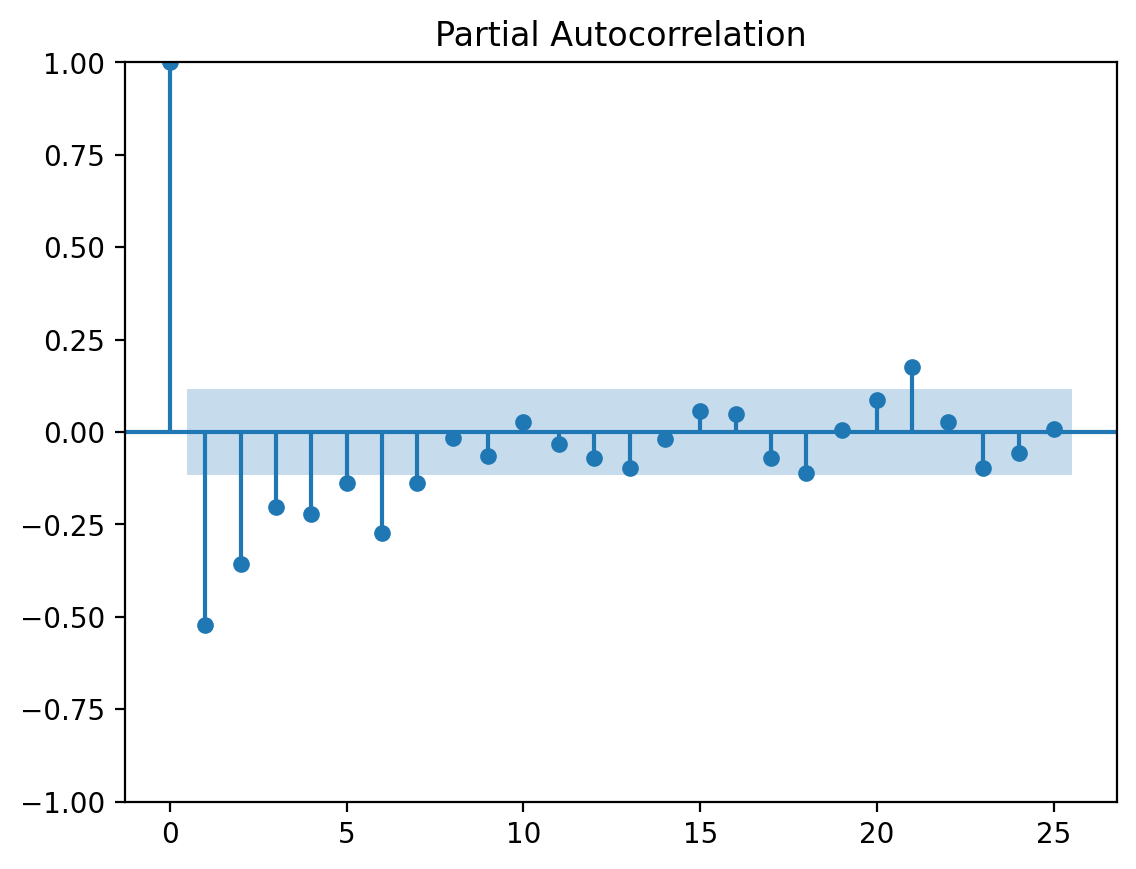

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(training_1d.fillna(method='bfill'));
plot_pacf(training_1d.fillna(method='bfill'));

Podemos ver que, por un lado, el gráfico ACF decrece de forma súbita a partir del retardo `k=1` (la segunda barra vertical), mientras que el gráfico de autocorrelación parcial va creciendo de forma más progresiva retardo. Esto da indicios de que el modelo que se puede ajustar bien a estos datos será de tipo `ARIMA(0,1,1)`. 

A continuación podéis ver como entrenar este modelo y usarlo para realizar una predicción. 

In [8]:
test

2020-05-24    20.026583
2020-05-31    18.346412
2020-06-07    20.606890
2020-06-14    19.388908
2020-06-21    19.743459
2020-06-28    18.121413
2020-07-05    20.409863
2020-07-12    19.920587
2020-07-19    20.564667
2020-07-26    18.666784
2020-08-02    18.845896
2020-08-09    21.662891
2020-08-16    18.331010
2020-08-23    19.287127
2020-08-30    20.592020
2020-09-06    19.584904
2020-09-13    20.102184
2020-09-20    19.151833
2020-09-27    19.953389
2020-10-04    18.308858
2020-10-11    21.305567
2020-10-18    19.561323
2020-10-25    19.031360
2020-11-01    20.409973
2020-11-08    19.314921
2020-11-15    18.473434
2020-11-22    18.493026
2020-11-29    20.565568
2020-12-06    19.744273
2020-12-13    19.802196
2020-12-20    21.045693
2020-12-27    18.873174
Freq: W-SUN, dtype: float64

In [9]:
from statsmodels.tsa.arima.model import ARIMA
params = (0,1,1)
m = ARIMA(training, order=params)
result = m.fit()
prediction = pd.Series(result.forecast(len(test))[0], index=test.index)

In [10]:
result.forecast(len(test))[0]

18.74046500816288

In [11]:
prediction

2020-05-24    18.740465
2020-05-31    18.740465
2020-06-07    18.740465
2020-06-14    18.740465
2020-06-21    18.740465
2020-06-28    18.740465
2020-07-05    18.740465
2020-07-12    18.740465
2020-07-19    18.740465
2020-07-26    18.740465
2020-08-02    18.740465
2020-08-09    18.740465
2020-08-16    18.740465
2020-08-23    18.740465
2020-08-30    18.740465
2020-09-06    18.740465
2020-09-13    18.740465
2020-09-20    18.740465
2020-09-27    18.740465
2020-10-04    18.740465
2020-10-11    18.740465
2020-10-18    18.740465
2020-10-25    18.740465
2020-11-01    18.740465
2020-11-08    18.740465
2020-11-15    18.740465
2020-11-22    18.740465
2020-11-29    18.740465
2020-12-06    18.740465
2020-12-13    18.740465
2020-12-20    18.740465
2020-12-27    18.740465
Freq: W-SUN, dtype: float64

El código anterior entrena un modelo ARIMA con los parámetros que hemos indicado anteriormente y luego realiza una predicción de tanto valores como tiene el test. Veamos una gráfica de esta predicción. 

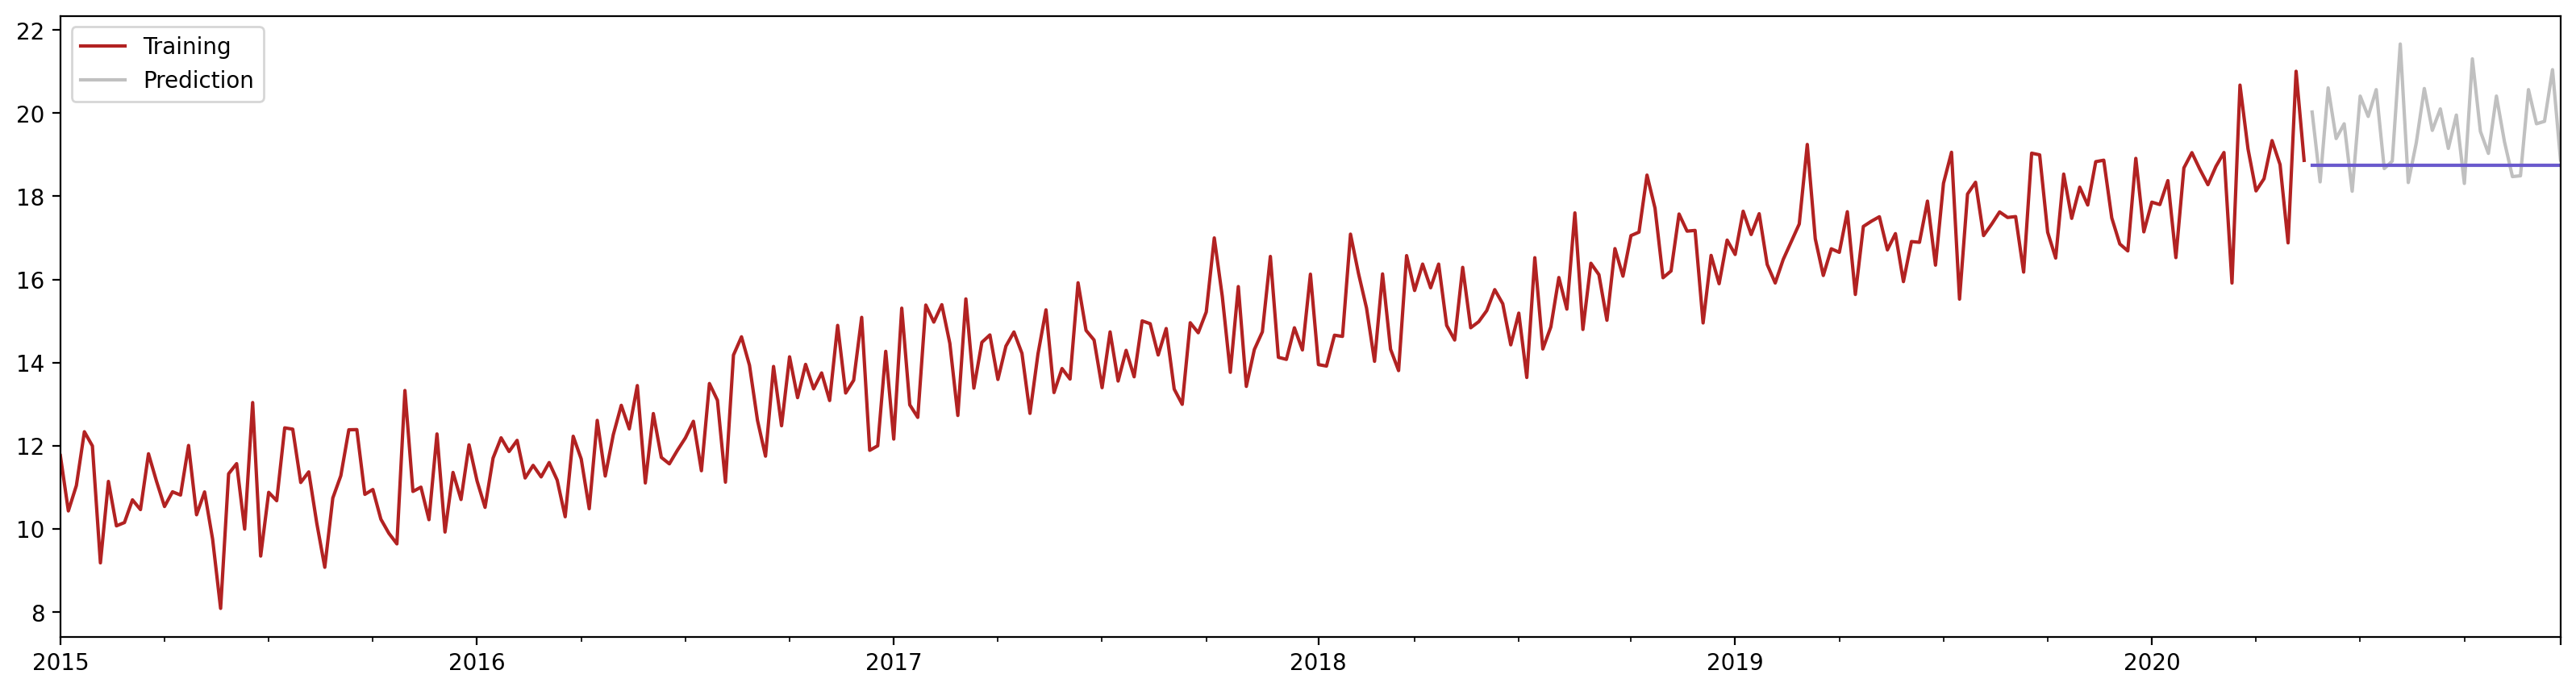

In [12]:
training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
prediction.plot(figsize=(20,5), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])

Parece que el modelo de ARIMA ha capturado de forma más o menos correcta la posible tendencia de la serie. 


### <font color="#00586D"> 2.2. SARIMA</font>

Veamos ahora como estimar un modelo ARIMA estacional. Para ello, vamos a añadir una componente estacional a la serie

In [29]:
noise

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
        0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
       -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
       -1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877,
        0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215,
        0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275,
       -1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218,
       -0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028,
       -0.89546656,  0.3869025 , -0.51080514, -1.18063218, -0.02818223,
        0.42833187,  0.06651722,  0.3024719 , -0.63432209, -0.36274117,
       -0.67246045, -0.35955316, -0.81314628, -1.7262826 ,  0.17742614,
       -0.40178094, -1.63019835,  0.46278226, -0.90729836,  0.05

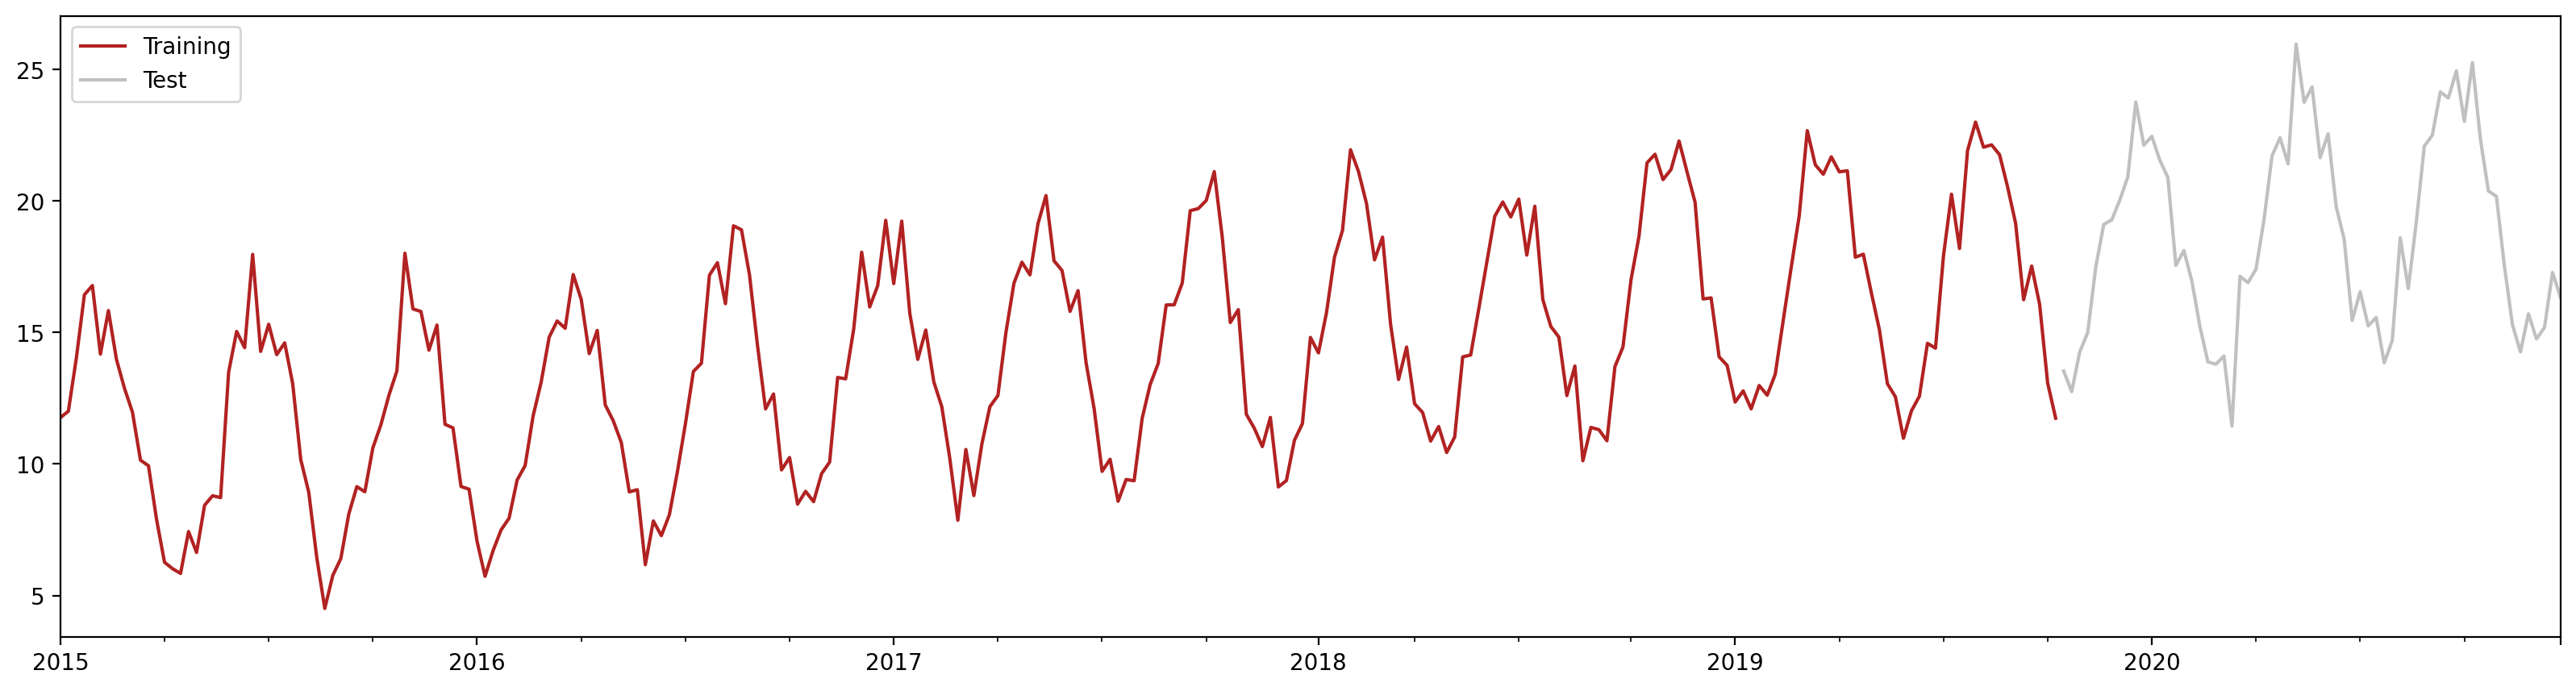

In [13]:

seasonality = np.sin(np.linspace(start=0, stop=100, num=size)) * 5
y = level + trend + noise + seasonality
ts = pd.Series(y, index=dates)
n = len(ts)
split = 0.2 # % de datos para test
n_training = int((1-split)*n)
training = ts[:n_training]
test = ts[n_training:]
training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
plt.legend(['Training', 'Test'])

Procederemos aplicando diferencias hasta obtener una serie estacionaria. Esta serie presenta claramente tanto un componente estacional como tendencia. A veces, solo es necesario aplicar la diferencia estacional para hacer la serie estacionaria y otras veces necesitaremos las dos. Empezaremos por la estacional. Para ello necesitaremos saber el tamaño de la estación. Podemos hacerlo visualizando la serie. 

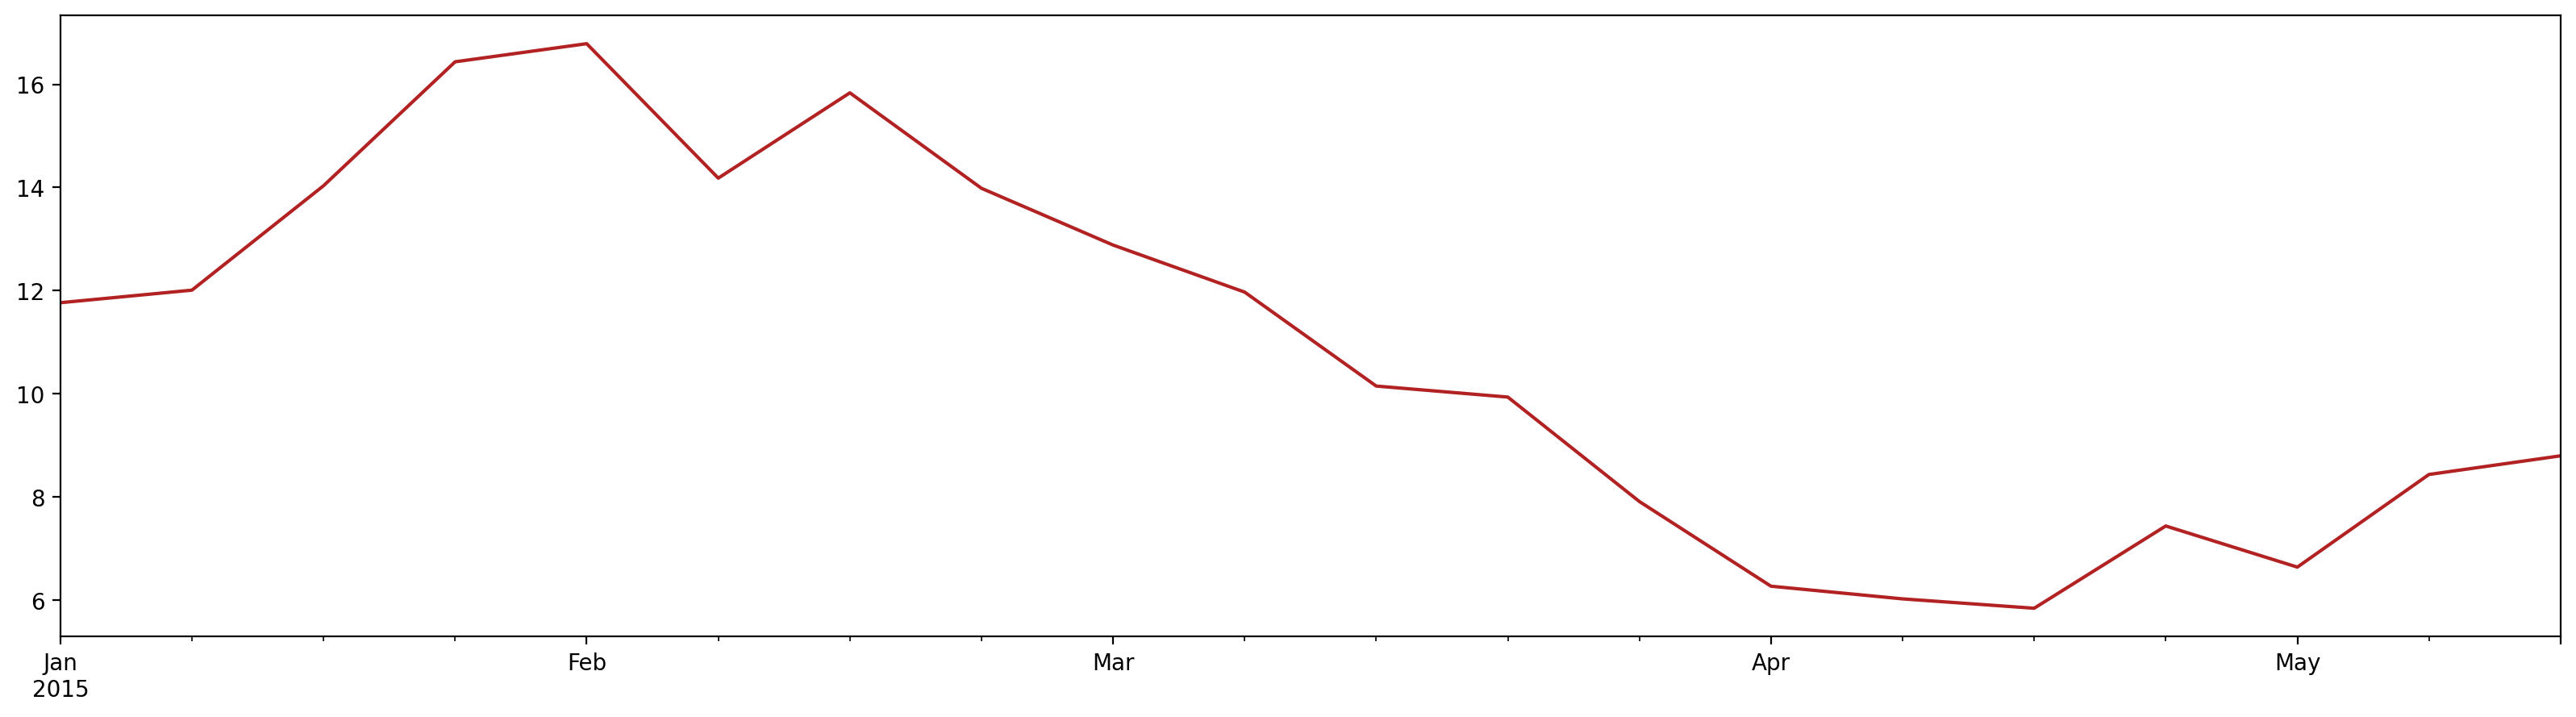

In [14]:
seasonal_lag = 20

training[:seasonal_lag].plot(figsize=(20,5), color='firebrick', ls='-');


Aproximadamente, parece que el periodo dura unos 20 días. Apliquemos una diferencia. 

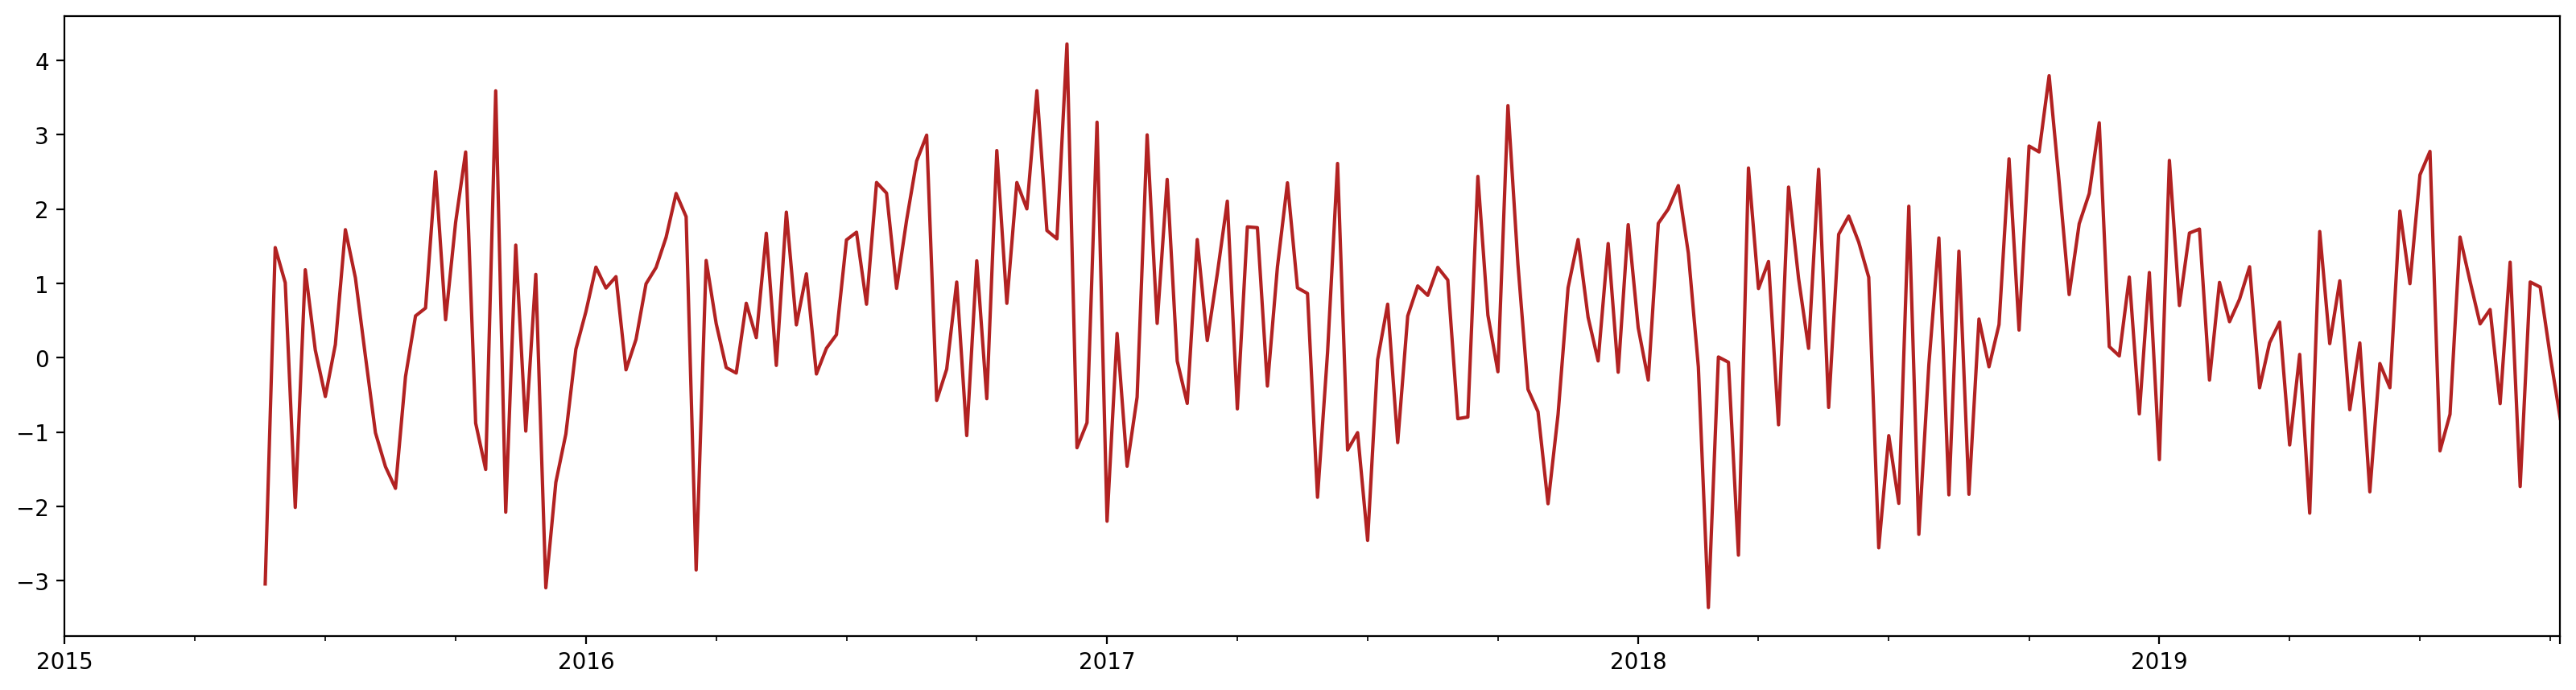

In [15]:
training_1sd = training - training.shift(seasonal_lag)
training_1sd.plot(figsize=(20,5), color='firebrick');

Vemos que únicamente con la diferencia estacional hemos obtenido una serie que parece estacionaria. Vamos a comprobarlo con el test de Dickey-Fuller. 

In [16]:
adfuller(training_1sd.fillna(method='bfill'))[1]

1.5273897581647074e-05

Veamos ahora las gráficas de autocorrelación. 

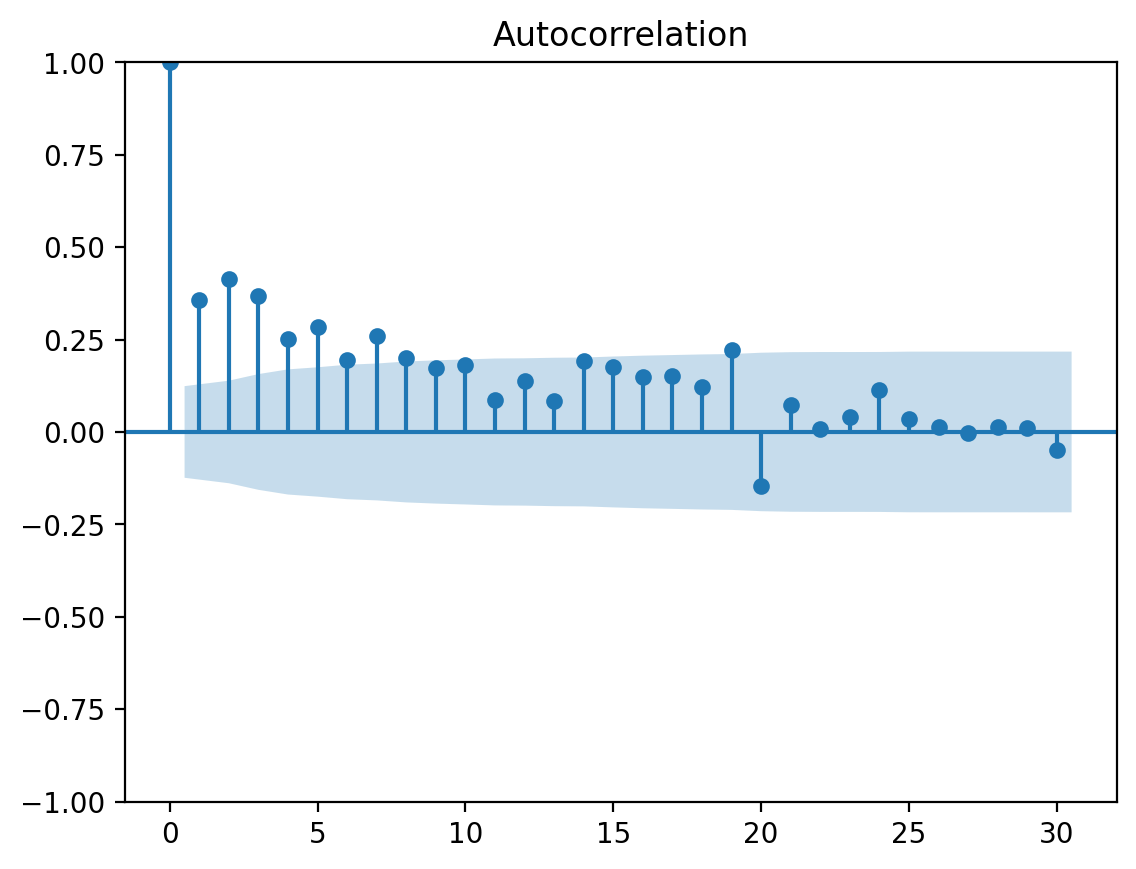

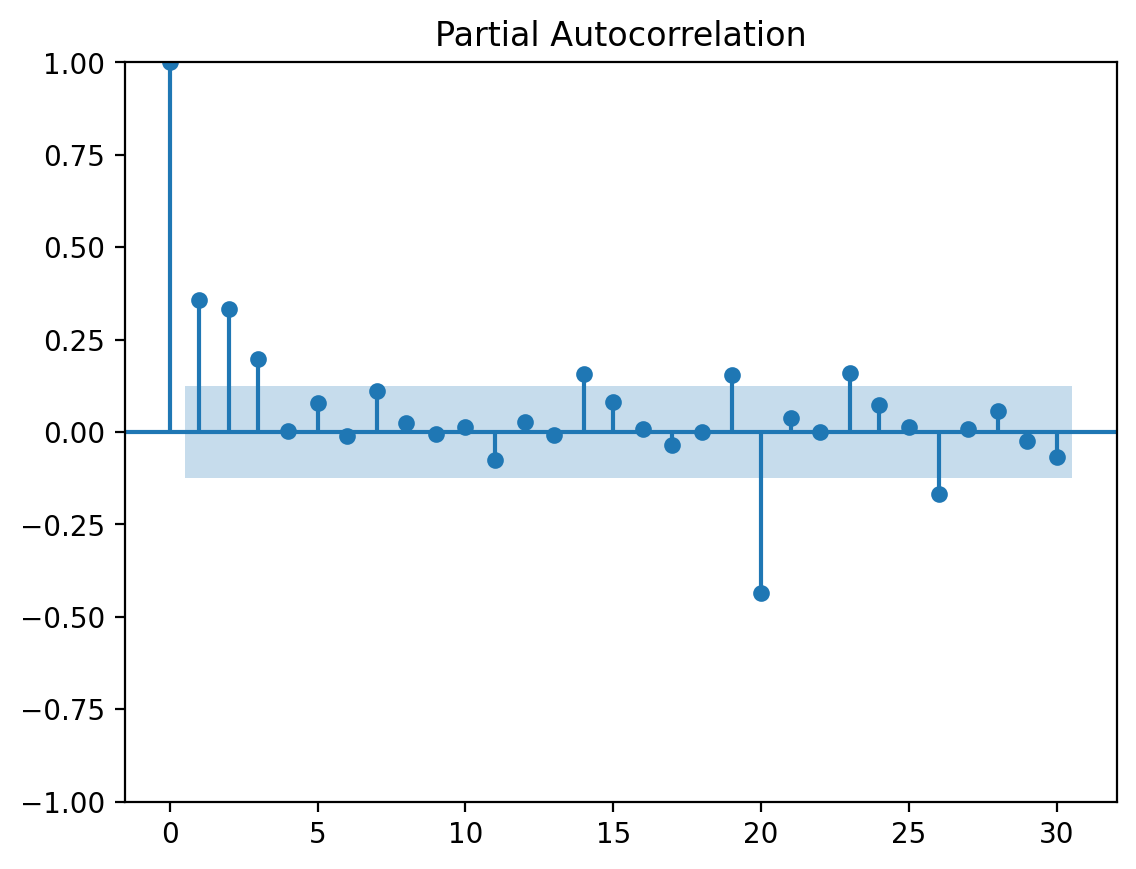

In [17]:
plot_acf(training_1sd.fillna(method='bfill'), lags=30);
plot_pacf(training_1sd.fillna(method='bfill'), lags=30);

Parece que el gráfico de autocorrelación disminuye paulatinamente mientras que el gráfico de autocorrelación disminuye más brúscamente en k=2. Esto indica un valor de p=2. Para ver los valores de P y Q (de la parte estacional del modelo) necesitamos ver las autocorrelaciones en las estaciones.

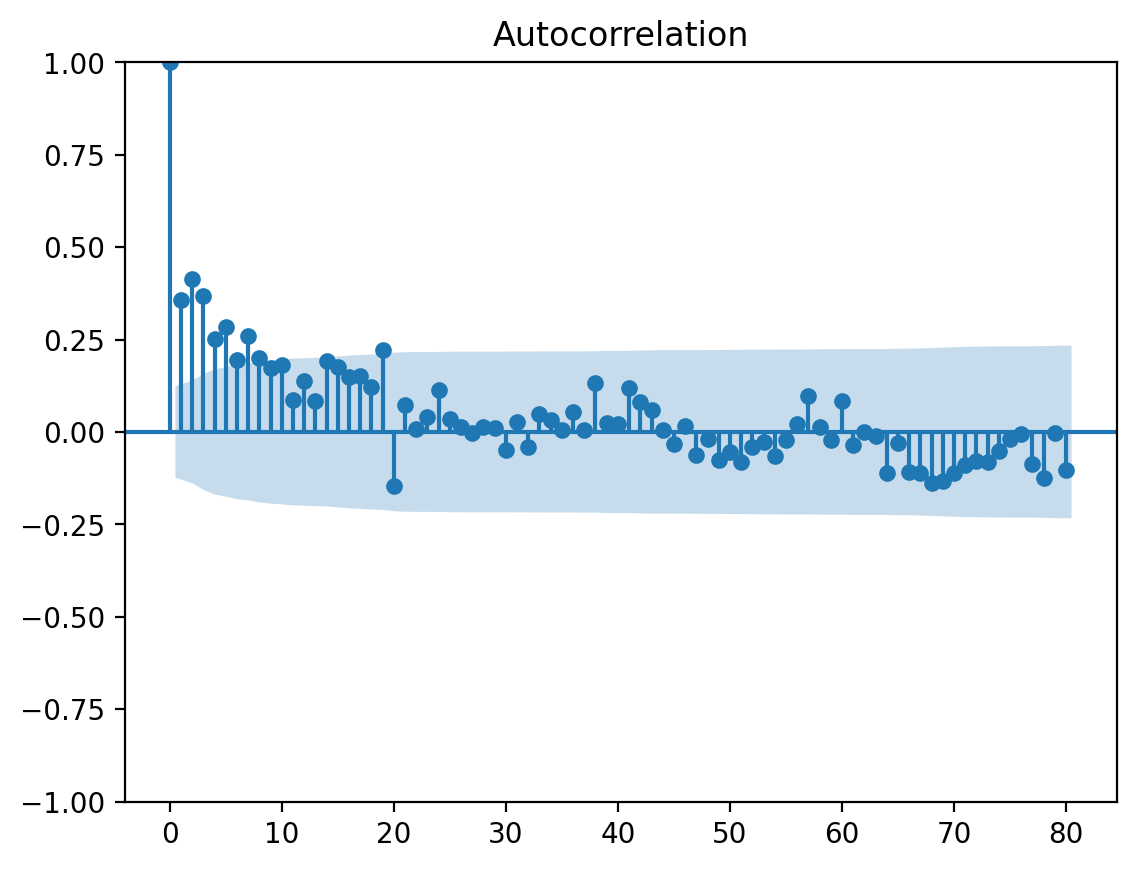

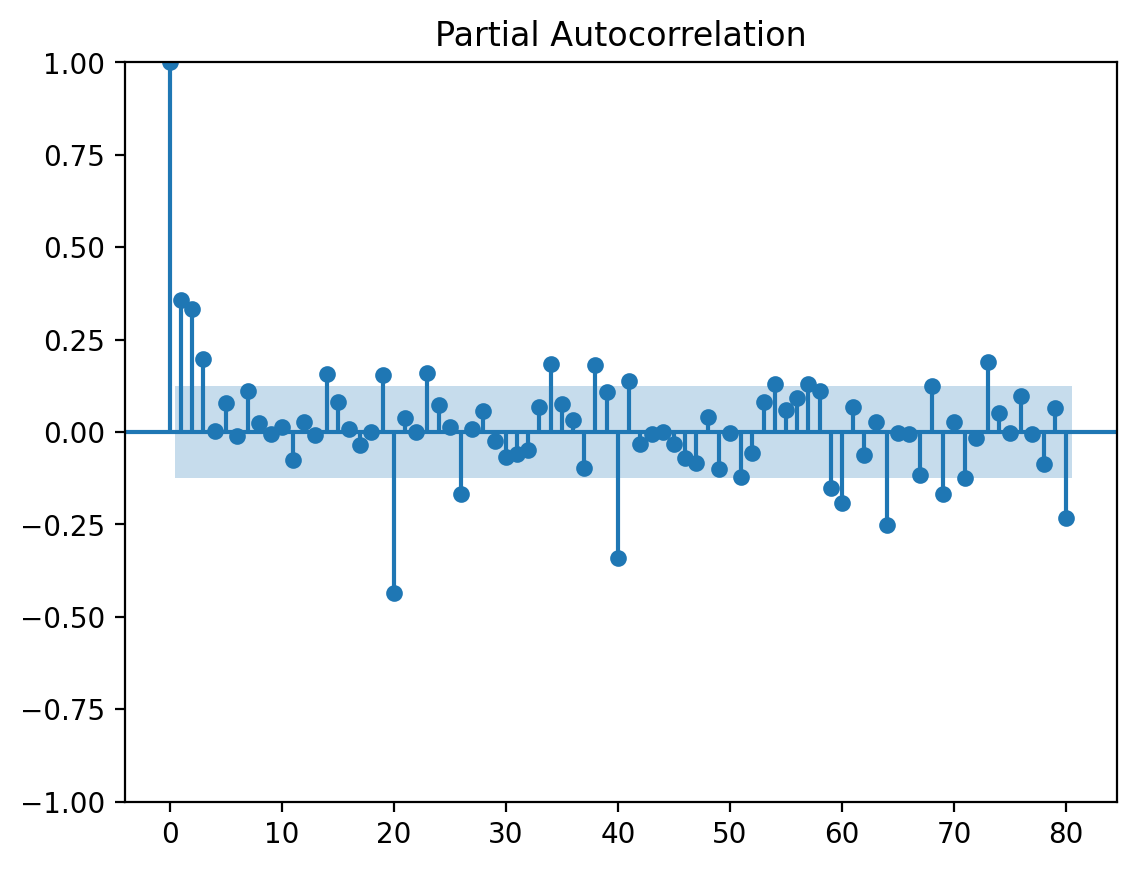

In [18]:
plot_acf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*4);
plot_pacf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*4);

Vemos que en las estaciones, el gráfico de autocorrelación parcial parece decrecer poco a poco. En cambio, en el de autocorrelación, parece disminuir de forma más súbita a partir del primer retardo estacional. Esto parece indicar, un modelo tipo MA por lo que podríamos empezar probando un `SARIMA(0,0,0)(0,1,1,20)`. Veamos el resultado.  

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

season = seasonal_lag
params = (2,0,0)
seasonal_params = (0,1,1, seasonal_lag)
m = SARIMAX(training, order=params, seasonal_order=seasonal_params)
result = m.fit()
prediction = pd.Series(result.forecast(len(test)), index=test.index)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65784D+00    |proj g|=  2.15572D-01


 This problem is unconstrained.



At iterate    5    f=  1.60939D+00    |proj g|=  1.72169D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   8.425D-06   1.609D+00
  F =   1.6092221859747922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


MAE:  2.4410265562306117


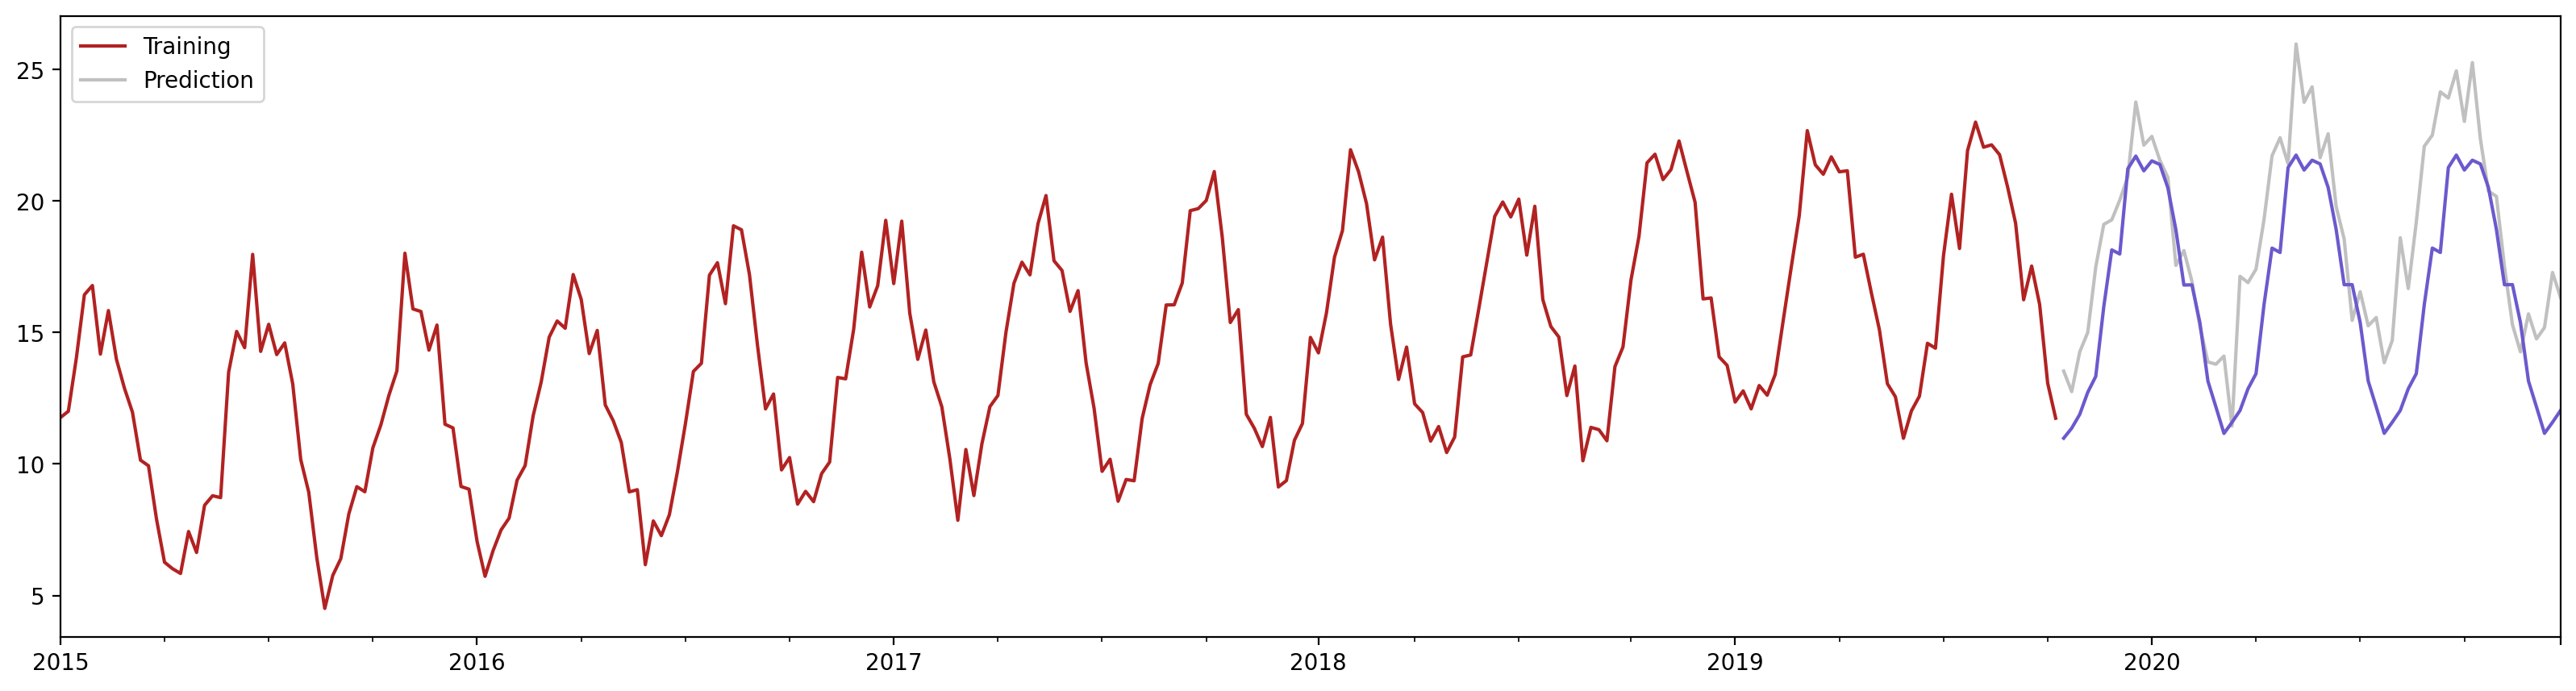

In [20]:
from sklearn.metrics import mean_absolute_error


training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
prediction.plot(figsize=(20,5), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])
print('MAE: ', mean_absolute_error(test, prediction))

Como se puede ver obtenemos un resultado aceptable, sobre todo para los casos más recientes.  

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicio 1</font>

Usando el conjunto de datos de temperaturas que os cargamos a continuación, obtener un modelo ARIMA estacional. Ya os damos el conjunto dividido en entrenamiento y test. Asimismo, lo hemos agrupado semanalmente, para que el entrenamiento sea más rápido. 

In [21]:
ts = pd.read_csv(
    './data/meteo_retiro.csv', 
    sep=';', 
    parse_dates=['FECHA'], 
    index_col='FECHA', 
    encoding='latin9'
).loc['2000':, 'TMEDIA'].fillna(method='ffill').resample('2W').mean()
n = len(ts)
split = 0.2 # % de datos para test
n_training = int((1-split)*n)
training_temp = ts[:n_training]
test_temp = ts[n_training:]
training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
plt.legend(['Training', 'Test'])

FileNotFoundError: [Errno 2] No such file or directory: './data/meteo_retiro.csv'

In [ ]:
# Solución
seasonal_lag = 52
training_temp[:seasonal_lag].plot(figsize=(20,5), color='firebrick', ls='-');

In [ ]:
training_1sd = training_temp - training_temp.shift(seasonal_lag)
training_1sd.plot(figsize=(20,5), color='firebrick');

In [ ]:
adfuller(training_1sd.fillna(method='bfill'))[1]

Veamos ahora las gráficas de autocorrelación. 

In [ ]:
plot_acf(training_1sd.fillna(method='bfill'), lags=30);
plot_pacf(training_1sd.fillna(method='bfill'), lags=30);

In [ ]:
plot_acf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*3);
plot_pacf(training_1sd.fillna(method='bfill'), lags=seasonal_lag*3);

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

season = seasonal_lag
params = (0,0,0)
seasonal_params = (0,1,1, seasonal_lag)
m = SARIMAX(training_temp, order=params, seasonal_order=seasonal_params)
result = m.fit()
prediction = pd.Series(result.forecast(len(test_temp)), index=test_temp.index)

In [ ]:
###### 

In [ ]:

training_temp.plot(figsize=(20,5), color='firebrick', ls='-');
test_temp.plot(figsize=(20,5), color='silver', ls='-');
prediction.plot(figsize=(20,5), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])
print('MAE: ', mean_absolute_error(test_temp, prediction))

Resultado esperado:
- MAE: 1.8697  

![resultado](img/ej1.png)

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 


<a id="section3"></a>
## <font color="#00586D"> 2. ARIMA mediante búsqueda</font>
<br>

Aunque el método anterior de búsqueda de parámetros suele dar resultados aceptables y es interesante de cara a conocer mejor el método, normalmente nos decantaremos (si disponemos de recursos de cómputo suficientes) por una alternativa de búsqueda automática de estos parámetros. Al ser enteros, además, solo es necesario probar con ciertos valores. Para ello, existen varias librerías. Podríamos optar, por ejemplo, por usar grid search de `scikit-learn`. Sin embargo, existen algunas librerías específicas para esto, como la que os proponemos a continuación. 

In [ ]:
import pmdarima as pm

arima = pm.auto_arima(
    training,
    suppress_warnings=True,
    seasonal=True, 
    trace=True,
    max_iter=10,
    m=10
)
prediction = pd.Series(arima.predict(n_periods=len(test)), index=test.index)

In [ ]:
training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
prediction.plot(figsize=(20,5), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])
print('MAE: ', mean_absolute_error(test, prediction))

Este método nos permite modificar varios parámetros del proceso de búsqueda, como el máximo número de valores para p, d, q, etc. Nosotros, a parte de añadir la información de la estacionalidad y modificar qué es lo que imprime el modelo, hemos optado por solo hacer como máximo 10 iteraciones del algoritmo de optimización, con el objetivo de reducir el tiempo de entrenamiento. Asimismo, es compatible tanto con ARIMA estándar como estacional. Podéis ver la documentación de los diferentes parámetros que podéis probar en su documentación: [pm.auto_arima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima#pmdarima.arima.auto_arima) 

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicio 2</font>

Usando el conjunto de datos de temperaturas que os cargamos a continuación, obtener un modelo ARIMA estacional mediante búsqueda. 

In [ ]:
ts = pd.read_csv(
    './data/meteo_retiro.csv', 
    sep=';', 
    parse_dates=['FECHA'], 
    index_col='FECHA', 
    encoding='latin9'
).loc['2000':, 'TMEDIA'].fillna(method='ffill').resample('2W').mean()
n = len(ts)
split = 0.2 # % de datos para test
n_training = int((1-split)*n)
training_temp = ts[:n_training]
test_temp = ts[n_training:]
training.plot(figsize=(20,5), color='firebrick', ls='-');
test.plot(figsize=(20,5), color='silver', ls='-');
plt.legend(['Training', 'Test'])

In [ ]:
%%time
# Solución
arima = pm.auto_arima(
    training_temp,
    suppress_warnings=True,
    seasonal=True, 
    trace=True,
    max_iter=10,
    m=26
)
prediction = pd.Series(arima.predict(n_periods=len(test_temp)), index=test_temp.index)

In [ ]:
training_temp.plot(figsize=(20,5), color='firebrick', ls='-');
test_temp.plot(figsize=(20,5), color='silver', ls='-');
prediction.plot(figsize=(20,5), color='slateblue', ls='-');
plt.legend(['Training', 'Prediction'])
print('MAE: ', mean_absolute_error(test_temp, prediction))

Resultado esperado:
- MAE: 2.3480  

![resultado](img/ej2.png)

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 



<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#00586D"></i> </font></div>